In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import *
from gtv import *

# GTV for climate forecasting

This walkthrough demonstrates the basic functionality of the GTV forecasting system.

The objective function GTV solves is as follows:

$$ \hat{\beta} = \text{argmin}_\beta \left \{ \frac{1}{n} \sum_{i=t}^n \alpha^{n-t}(y_t - X_t\beta)^2  + \lambda_1 \| \beta \|_1 + \lambda_{TV} \| \Gamma \beta \|_1 \right\} $$

where $\Gamma$ is the [edge-incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix) of the graph induced by some covariance matrix. In our paper, we use the thresholded covariance matrix of Pacific SSTs from the 40 [CESM Large Ensembles](http://www.cesm.ucar.edu/projects/community-projects/LENS/). 


Here's a simple example that demonstrates the mechanics of the GTV library.

In [3]:
# load data and compute covariance matrix
X = pd.read_csv('data/X_obs.csv').values
y = pd.read_csv('data/y_avg.csv').values.reshape(1,-1)[0]
Xlens = pd.read_csv('data/X_lens.csv').values
fts = pd.read_csv('data/sst_columns.csv')

Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .5) # we threshold the covariance matrix at .5

# split data into train/test
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

Before GTV, we can investigate the predictive performance of just using Nino 3.4 and NZI as univariate predictors in a linear regression model, and using Nino 3.4 & NZI together in a bivariate regression model. This is a good baseline to compare GTV performance with:

In [4]:
tele_df = teleconnections(X, y, fts, .9)
tele_df

,Method,MSE,R2,Coefs,alpha
0,NZI,0.865319,0.234525,[-0.5804724951297076],0.9
1,Nino 3.4,0.981842,0.131446,[0.34361398500807017],0.9
2,Nino 3.4 & NZI,0.867096,0.232953,"[-0.5864973549813631, -0.006775971501037147]",0.9


Choose regularization parmeters via cross validation of the training data:

In [6]:
(l1, ltv) = gtv_cv(X_train, y_train, Dlens, .9, np.linspace(.01, 1, 5)/25, np.logspace(-2, -1, 5)/25)
print(l1, ltv)

0.0103 0.0007113117640155692


Now we solve the GTV objective and plot the solution:

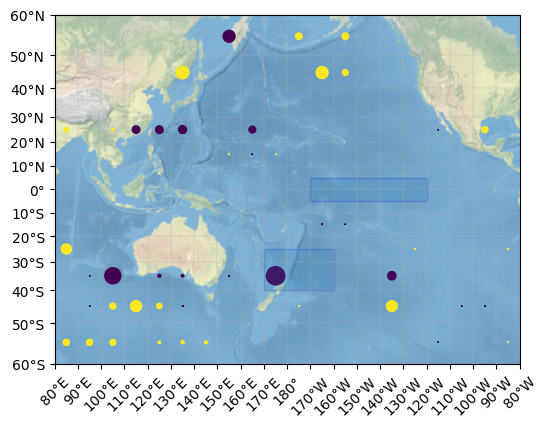

In [7]:
# solve GTV for a specified pair of regularization parameters 
# (use CV to find the optimal pair; these are just for demonstration)
beta = gtv_cvx(X_train, y_train, Dlens, lambda_lasso=.01, lambda_tv=.0007, alpha=.9)

# plot the solution
fts['coef'] = beta/2
plot_coefs(fts)

We can compute errors ($R^2$ on holdout data) over a 2D regularization path and plot them (this will be slow):

In [42]:
df = gtv_cvx_path(X, y, Dlens, np.linspace(.01, 1, 10)/25, np.logspace(-3, -1, 10)/25, alpha=.9)

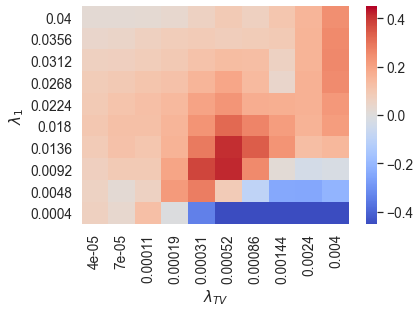

In [46]:
draw_lambda_contour(df.round(5), 'r2', vmin=-.45, vmax=.45)